# ClusterAI 2021

# Ciencia de Datos - Ingeniería Industrial - UTN BA

# clase_10: Practica Redes Neuronales - Regresion - Collaborative Filtering

### Elaborado por: Aguirre Nicolas

### Basado en :

1. [Neural Collaborative Filtering](https://arxiv.org/pdf/1708.05031.pdf)

1. **Deep Learning for Coders with fastai & PyTorchCollaborative Filtering Deep Dive, Chapter 8: Collaborative Filtering Deep Dive**

2. **Collaborative Filtering for Movie Recommendations:** https://keras.io/examples/structured_data/collaborative_filtering_movielens/

# Imports

In [2]:
 #Libreria de Redes Neronales
import tensorflow as tf
from tensorflow.keras import Model
from  tensorflow.keras.layers import Dense, Flatten, Embedding, Input , Dot, Add, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD ,Adam, RMSprop
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import regularizers 
print(tf.__version__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
pd.set_option('display.float_format', lambda x: '%.3f' % x) # Para acotar los decimales en pandas

2.6.0


In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


# Dataset


In [3]:
path = '/content/gdrive/MyDrive/Colab Notebooks/ClusterAI/MovieLens/ml-100k'
path_save = '/content/gdrive/MyDrive/Colab Notebooks/ClusterAI/MovieLens/save/'

# Cargamos el dataset de usuarios, movie and rating
ratings = pd.read_csv(path+'/u.data', delimiter='\t', header=None,
 names=['user','movie','rating','timestamp'])
ratings.head()

# Cargamos la lista de movie ID y su nombre
movies = pd.read_csv(path+'/u.item', delimiter='|', encoding='latin-1',
 usecols=(0,1), names=('movie','title'), header=None)
movies.head()

# Agregamos el nombre de la pelicula al DF 'rating'
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [8]:
# Veamos la tabla de Usuario - Pelicula
user_movie_table = pd.pivot_table(ratings, values='rating', index=['user'],
                    columns=['movie'],fill_value=0)
user_movie_table

movie,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5,3,4,3,3,5,4,1,5,3,2,5,5,5,5,5,3,4,5,4,1,4,4,3,4,3,2,4,1,3,3,5,4,2,1,2,2,3,4,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,2,0,0,4,4,0,0,0,0,3,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,4,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,3,0,0,4,3,0,0,0,4,0,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0,0,0,0,0,0,0,0,5,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
940,0,0,0,2,0,0,4,5,3,0,0,4,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
941,5,0,0,0,0,0,4,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
# Separamos nuestras X e Y
x = ratings[['user','movie']].values
y = ratings[['rating']].values

## Split

In [ ]:
# Separamos train,validation y  test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

# Matrix Factorization (MF) 
![](https://drive.google.com/uc?id=18wsmjuUuA5u_bSNB-4_SjhD3kGx6wxHr)


## Lattent Space (Embedding)

In [10]:
q_users = len(ratings['user'].unique())
q_movies = len(ratings['movie'].unique())
lattent_space = 35
print('Cantidad de Peliculas:', q_users)
print('Cantidad de Peliculas:', q_movies)
print('Embedding Space: ', lattent_space)

Cantidad de Peliculas: 943
Cantidad de Peliculas: 1682
Embedding Space:  35


# 1) Modelo: MF

$R_{i,j} = L_{i}\cdot J^{T}_{j} $

Donde:

( $\cdot$ ) es el Producto Escalar

$L_{i}\in R^{943x35}$ es el *embedding* del usuario ${i}$

$L_{j}\in R^{1683x35}$ es el *embedding* del la pelicula ${j}$

Model: "Collab_Filtering"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_user (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
x_movies (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
u_vector (Embedding)            (None, 1, 35)        33005       x_user[0][0]                     
__________________________________________________________________________________________________
m_vector (Embedding)            (None, 1, 35)        58870       x_movies[0][0]                   
___________________________________________________________________________________

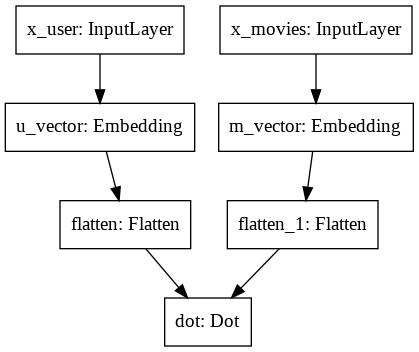

In [ ]:
# Para eliminar los modelos que hayan quedado guardados en memoria
tf.keras.backend.clear_session() 

input_x_user = Input(shape=(1), name="x_user")
input_x_movies = Input(shape=(1), name="x_movies")

# Rama de Usuarios
user_vector = Embedding(input_dim = q_users,output_dim = lattent_space,
                         name="u_vector")(input_x_user)
# Rama de Peliculas
movie_vector = Embedding(input_dim = q_movies,output_dim = lattent_space,
                          name="m_vector")(input_x_movies)

# Dot Product [User*Movie]
user_vector = Flatten()(user_vector)                         
movie_vector = Flatten()(movie_vector)                         
dot_movie_user = Dot(axes=1)([user_vector, movie_vector])


# El modelo quedara definido por las variables de entrada y de salidas (y su correspondiente "camino")
Collab_Filtering = Model(inputs = [input_x_user,input_x_movies],
                         outputs = dot_movie_user, name="Collab_Filtering")
Collab_Filtering.summary()
tf.keras.utils.plot_model(Collab_Filtering)

## Optimizador & Funcion de Penalizacion

In [ ]:
# Optimizador
lr = 0.01
opt = Adam(learning_rate=lr)
# Funcion de penalizacion
loss_func = MeanSquaredError()

## Compile

In [ ]:
Collab_Filtering.compile(optimizer = opt,
              loss = loss_func,
              metrics = ['mse','mae'])

## Train

In [ ]:
# Batch Size
bs = 128
epochs_training = 50
# Para reducir el learning rate cuando la loss de validacion no mejora
callbacks_fn = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                    patience = int (epochs_training*0.3),
                                                    factor = 0.5,verbose=1)

# Para guardar el modelo cuando la loss de validacion mejora.
name = 'Collab_Filtering'
callback_chp = tf.keras.callbacks.ModelCheckpoint(
    path_save+name,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False)

In [ ]:
# Entrenamos!
training_0 = Collab_Filtering.fit(x = [x_train[:,0],x_train[:,1]],
                                y = y_train,
                                batch_size = bs,
                                epochs = epochs_training,
                                validation_data = ([x_val[:,0],x_val[:,1]],y_val),
                                callbacks = [callbacks_fn,callback_chp],
                                verbose = 1)

Epoch 1/50
500/500 [==============================] - 3s 5ms/step - loss: 4.2527 - mse: 4.2527 - mae: 1.5484 - val_loss: 1.1492 - val_mse: 1.1492 - val_mae: 0.8389
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering/assets


Epoch 2/50
500/500 [==============================] - 2s 4ms/step - loss: 0.9656 - mse: 0.9656 - mae: 0.7711 - val_loss: 1.1152 - val_mse: 1.1152 - val_mae: 0.8257
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering/assets


Epoch 3/50
500/500 [==============================] - 2s 4ms/step - loss: 0.7422 - mse: 0.7422 - mae: 0.6746 - val_loss: 1.1692 - val_mse: 1.1692 - val_mae: 0.8450
Epoch 4/50
500/500 [==============================] - 2s 5ms/step - loss: 0.5940 - mse: 0.5940 - mae: 0.6022 - val_loss: 1.2424 - val_mse: 1.2424 - val_mae: 0.8710
Epoch 5/50
500/500 [==============================] - 2s 4ms/step - loss: 0.5141 - mse: 0.5141 - mae: 0.5584 - val_loss: 1.3055 - val_mse: 1.3055 - val_mae: 0.8968
Epoch 6/50
500/500 [==============================] - 2s 5ms/step - loss: 0.4654 - mse: 0.4654 - mae: 0.5307 - val_loss: 1.3605 - val_mse: 1.3605 - val_mae: 0.9102
Epoch 7/50
500/500 [==============================] - 2s 4ms/step - loss: 0.4414 - mse: 0.4414 - mae: 0.5163 - val_loss: 1.4154 - val_mse: 1.4154 - val_mae: 0.9302
Epoch 8/50
500/500 [==============================] - 2s 5ms/step - loss: 0.4291 - mse: 0.4291 - mae: 0.5084 - val_loss: 1.4505 - val_mse: 1.4505 - val_mae: 0.9402
Epoch 9/50
500/5

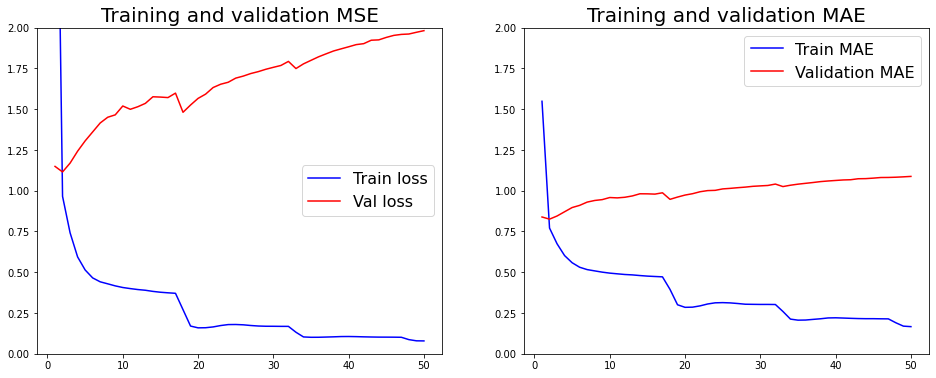

In [ ]:
# MSE
loss_hist = training_0.history['loss']
val_loss_hist = training_0.history['val_loss']
# MAE
train_mae_hist = training_0.history['mae']
val_mae_hist = training_0.history['val_mae']
epochs = range(1, len(loss_hist) + 1)

fig, axs = plt.subplots(1,2,figsize=(16,6))
axs[0].plot(epochs, loss_hist, 'b', label='Train loss')
axs[0].plot(epochs, val_loss_hist, 'r', label='Val loss')
axs[0].set_title('Training and validation MSE',fontsize=20)
axs[0].legend(fontsize=16)
axs[1].plot(epochs, train_mae_hist, 'b', label='Train MAE')
axs[1].plot(epochs, val_mae_hist, 'r', label='Validation MAE')
axs[1].set_title('Training and validation MAE',fontsize=20)
axs[1].legend(fontsize=16)
axs[0].set_ylim(0,2)
axs[1].set_ylim(0,2)
plt.show()

## Test

In [ ]:
Collab_Filtering = tf.keras.models.load_model(path_save+name)
Collab_Filtering.evaluate(x = [x_test[:,0],x_test[:,1]],
                                y = y_test,verbose=2)

625/625 - 1s - loss: 1.1108 - mse: 1.1108 - mae: 0.8229


[1.1108390092849731, 1.1108390092849731, 0.8228991031646729]

# 2) Modelo: MF + Bias

$R_{i,j} = L_{i} \cdot L^{T}_{j}   + b_{i} + b_{j}$

Donde:

$L_{i}$ es el *embedding* del usuario ${i}$

$L_{j}$ es el *embedding* del la pelicula ${j}$

$b_{i}$ es el *bias* del usuario ${i}$

$b_{j}$ es el *bias* del la pelicula ${j}$




Model: "Collab_Filtering_bias"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_user (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
x_movies (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
u_vector (Embedding)            (None, 1, 35)        33005       x_user[0][0]                     
__________________________________________________________________________________________________
m_vector (Embedding)            (None, 1, 35)        58870       x_movies[0][0]                   
______________________________________________________________________________

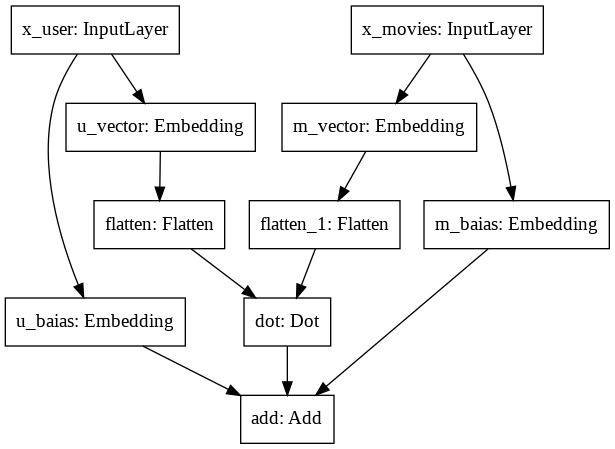

In [ ]:
# Para eliminar los modelos que hayan quedado guardados en memoria
tf.keras.backend.clear_session() 

input_x_user = Input(shape=(1), name="x_user")
input_x_movies = Input(shape=(1), name="x_movies")

# Rama de Usuarios
user_vector = Embedding(input_dim = q_users,output_dim = lattent_space,
                         name="u_vector")(input_x_user)
user_bias = Embedding(input_dim = q_users,output_dim = 1,
                       name="u_baias")(input_x_user)
# Rama de Peliculas
movie_vector = Embedding(input_dim = q_movies,output_dim = lattent_space,
                          name="m_vector")(input_x_movies)
movie_bias = Embedding(input_dim = q_movies,output_dim = 1,
                        name="m_baias")(input_x_movies)
# Dot Product User*Movie
user_vector = Flatten()(user_vector)                         
movie_vector = Flatten()(movie_vector)                         
dot_movie_user = Dot(axes=1)([user_vector, movie_vector])

# Sumamos el Bias de las peliculas
prediction = Add()([dot_movie_user, user_bias,movie_bias])

Collab_Filtering_bias = Model(inputs = [input_x_user,input_x_movies],
                         outputs = prediction, name="Collab_Filtering_bias")
Collab_Filtering_bias.summary()
tf.keras.utils.plot_model(Collab_Filtering_bias)


In [ ]:
# Compilamos
Collab_Filtering_bias.compile(optimizer = opt,
              loss = loss_func,
              metrics = ['mse','mae'])

## Train

In [ ]:
# Para guardar el modelo cuando la loss de validacion mejora.
name = 'Collab_Filtering_bias'
callback_chp = tf.keras.callbacks.ModelCheckpoint(
    path_save+name,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False)

# Entrenamos!
training_1 = Collab_Filtering_bias.fit(x = [x_train[:,0],x_train[:,1]],
                                y = y_train,
                                batch_size = bs,
                                epochs=epochs_training,
                                validation_data = ([x_val[:,0],x_val[:,1]],y_val),
                                callbacks=[callbacks_fn,callback_chp],
                                verbose=1)

Epoch 1/50
500/500 [==============================] - 4s 6ms/step - loss: 5.4082 - mse: 5.4082 - mae: 1.9021 - val_loss: 1.3772 - val_mse: 1.3772 - val_mae: 0.9187
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_bias/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_bias/assets


Epoch 2/50
 21/500 [>.............................] - ETA: 2s - loss: 1.2355 - mse: 1.2355 - mae: 0.8567

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


500/500 [==============================] - 3s 6ms/step - loss: 1.0772 - mse: 1.0772 - mae: 0.8117 - val_loss: 1.0150 - val_mse: 1.0150 - val_mae: 0.7881
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_bias/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_bias/assets


Epoch 3/50
 20/500 [>.............................] - ETA: 2s - loss: 0.8841 - mse: 0.8841 - mae: 0.7294

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


500/500 [==============================] - 3s 5ms/step - loss: 0.8997 - mse: 0.8997 - mae: 0.7431 - val_loss: 0.9444 - val_mse: 0.9444 - val_mae: 0.7591
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_bias/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_bias/assets


Epoch 4/50
 22/500 [>.............................] - ETA: 2s - loss: 0.7988 - mse: 0.7988 - mae: 0.6951

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


500/500 [==============================] - 3s 5ms/step - loss: 0.8330 - mse: 0.8330 - mae: 0.7150 - val_loss: 0.9207 - val_mse: 0.9207 - val_mae: 0.7498
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_bias/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_bias/assets


Epoch 5/50
 22/500 [>.............................] - ETA: 2s - loss: 0.7514 - mse: 0.7514 - mae: 0.6817

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


500/500 [==============================] - 3s 5ms/step - loss: 0.7872 - mse: 0.7872 - mae: 0.6944 - val_loss: 0.9064 - val_mse: 0.9064 - val_mae: 0.7449
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_bias/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_bias/assets


Epoch 6/50
 22/500 [>.............................] - ETA: 2s - loss: 0.7073 - mse: 0.7073 - mae: 0.6539

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


500/500 [==============================] - 3s 5ms/step - loss: 0.7484 - mse: 0.7484 - mae: 0.6770 - val_loss: 0.8946 - val_mse: 0.8946 - val_mae: 0.7395
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_bias/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_bias/assets


Epoch 7/50
 24/500 [>.............................] - ETA: 2s - loss: 0.6843 - mse: 0.6843 - mae: 0.6418

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


500/500 [==============================] - 3s 5ms/step - loss: 0.7111 - mse: 0.7111 - mae: 0.6589 - val_loss: 0.8892 - val_mse: 0.8892 - val_mae: 0.7370
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_bias/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_bias/assets


Epoch 8/50
 20/500 [>.............................] - ETA: 2s - loss: 0.6482 - mse: 0.6482 - mae: 0.6262

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


500/500 [==============================] - 3s 6ms/step - loss: 0.6742 - mse: 0.6742 - mae: 0.6407 - val_loss: 0.8898 - val_mse: 0.8898 - val_mae: 0.7370
Epoch 9/50
500/500 [==============================] - 3s 5ms/step - loss: 0.6372 - mse: 0.6372 - mae: 0.6227 - val_loss: 0.8913 - val_mse: 0.8913 - val_mae: 0.7377
Epoch 10/50
500/500 [==============================] - 3s 6ms/step - loss: 0.5997 - mse: 0.5997 - mae: 0.6028 - val_loss: 0.8953 - val_mse: 0.8953 - val_mae: 0.7398
Epoch 11/50
500/500 [==============================] - 3s 5ms/step - loss: 0.5625 - mse: 0.5625 - mae: 0.5825 - val_loss: 0.9036 - val_mse: 0.9036 - val_mae: 0.7422
Epoch 12/50
500/500 [==============================] - 3s 6ms/step - loss: 0.5268 - mse: 0.5268 - mae: 0.5623 - val_loss: 0.9139 - val_mse: 0.9139 - val_mae: 0.7462
Epoch 13/50
500/500 [==============================] - 3s 5ms/step - loss: 0.4931 - mse: 0.4931 - mae: 0.5426 - val_loss: 0.9240 - val_mse: 0.9240 - val_mae: 0.7501
Epoch 14/50
500/500 [==

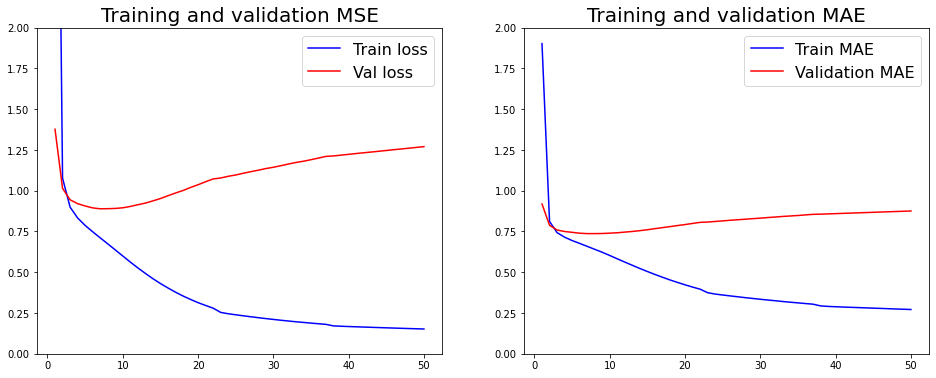

In [ ]:
# MSE
loss_hist = training_1.history['loss']
val_loss_hist = training_1.history['val_loss']
# MAE
train_mae_hist = training_1.history['mae']
val_mae_hist = training_1.history['val_mae']
epochs = range(1, len(loss_hist) + 1)

fig, axs = plt.subplots(1,2,figsize=(16,6))
axs[0].plot(epochs, loss_hist, 'b', label='Train loss')
axs[0].plot(epochs, val_loss_hist, 'r', label='Val loss')
axs[0].set_title('Training and validation MSE',fontsize=20)
axs[0].legend(fontsize=16)
axs[1].plot(epochs, train_mae_hist, 'b', label='Train MAE')
axs[1].plot(epochs, val_mae_hist, 'r', label='Validation MAE')
axs[1].set_title('Training and validation MAE',fontsize=20)
axs[1].legend(fontsize=16)
axs[0].set_ylim(0,2)
axs[1].set_ylim(0,2)
plt.show()

## Test

In [ ]:
Collab_Filtering_bias = tf.keras.models.load_model(path_save+name)
Collab_Filtering_bias.evaluate(x = [x_test[:,0],x_test[:,1]],
                                y = y_test,verbose=2)

625/625 - 1s - loss: 0.8889 - mse: 0.8889 - mae: 0.7361


[0.8888710737228394, 0.8888710737228394, 0.7360888123512268]

# 3) Modelo: MF + Bias + Regularization

$R_{i,j} = L_{i} \cdot L^{T}_{j}   + b_{i} + b_{j}$

Donde:

$L_{i}$ es el *embedding* del usuario ${i}$

$L_{j}$ es el *embedding* del la pelicula ${j}$

$b_{i}$ es el *bias* del usuario ${i}$

$b_{j}$ es el *bias* del la pelicula ${j}$

Model: "Collab_Filtering_bias_reg"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_user (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
x_movies (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
u_vector (Embedding)            (None, 1, 35)        33005       x_user[0][0]                     
__________________________________________________________________________________________________
m_vector (Embedding)            (None, 1, 35)        58870       x_movies[0][0]                   
__________________________________________________________________________

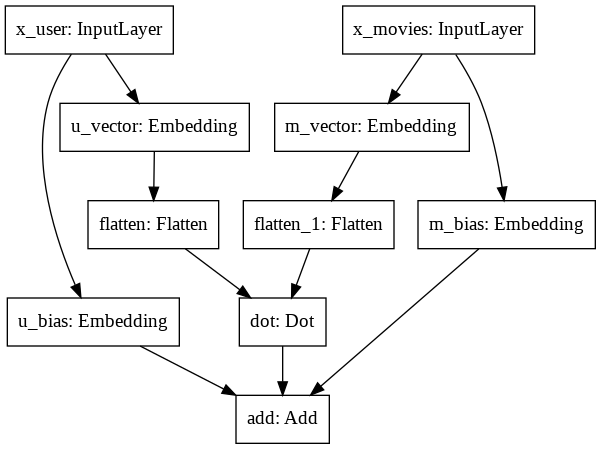

In [ ]:
# Para eliminar los modelos que hayan quedado guardados en memoria
tf.keras.backend.clear_session() 

lambda_value = 1e-3

input_x_user = Input(shape=(1), name="x_user")
input_x_movies = Input(shape=(1), name="x_movies")

# Rama de Usuarios
user_vector = Embedding(input_dim = q_users,output_dim = lattent_space,
                        embeddings_regularizer = regularizers.l2(lambda_value),                        
                         name="u_vector")(input_x_user)

user_bias = Embedding(input_dim = q_users,output_dim = 1,
                       name="u_bias")(input_x_user)
# Rama de Peliculas
movie_vector = Embedding(input_dim = q_movies,output_dim = lattent_space,
                         embeddings_regularizer=regularizers.l2(lambda_value),
                          name="m_vector")(input_x_movies)
movie_bias = Embedding(input_dim = q_movies,output_dim = 1,
                        name="m_bias")(input_x_movies)
# Dot Product User*Movie
user_vector = Flatten()(user_vector)                         
movie_vector = Flatten()(movie_vector)                         
dot_movie_user = Dot(axes=1)([user_vector, movie_vector])
# Sumamos el Bias de las peliculas
prediction = Add()([dot_movie_user, user_bias,movie_bias])


Collab_Filtering_bias_reg = Model(inputs = [input_x_user,input_x_movies],
                         outputs = prediction, name="Collab_Filtering_bias_reg")
Collab_Filtering_bias_reg.summary()
tf.keras.utils.plot_model(Collab_Filtering_bias_reg)


In [ ]:
# Compilamos
Collab_Filtering_bias_reg.compile(optimizer = opt,
              loss = loss_func,
              metrics = ['mse','mae'])

## Train

In [ ]:
# Para guardar el modelo cuando la loss de validacion mejora.
name = 'Collab_Filtering_bias_reg'
callback_chp = tf.keras.callbacks.ModelCheckpoint(
    path_save+name,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False)

# Entrenamos!
training_2 = Collab_Filtering_bias_reg.fit(x = [x_train[:,0],x_train[:,1]],
                                y = y_train,
                                batch_size = bs,
                                epochs=epochs_training*5,
                                validation_data = ([x_val[:,0],x_val[:,1]],y_val),
                                callbacks=[callbacks_fn],
                                verbose=1)

Epoch 1/250
500/500 [==============================] - 4s 5ms/step - loss: 13.0994 - mse: 13.0820 - mae: 3.4372 - val_loss: 12.6809 - val_mse: 12.6660 - val_mae: 3.3771
Epoch 2/250
500/500 [==============================] - 3s 5ms/step - loss: 12.1761 - mse: 12.1231 - mae: 3.2968 - val_loss: 11.6655 - val_mse: 11.5465 - val_mae: 3.2101
Epoch 3/250
500/500 [==============================] - 2s 5ms/step - loss: 10.9294 - mse: 10.6950 - mae: 3.0758 - val_loss: 10.2642 - val_mse: 9.8973 - val_mae: 2.9450
Epoch 4/250
500/500 [==============================] - 2s 5ms/step - loss: 9.4945 - mse: 8.9740 - mae: 2.7846 - val_loss: 8.8757 - val_mse: 8.1948 - val_mae: 2.6419
Epoch 5/250
500/500 [==============================] - 2s 5ms/step - loss: 8.1923 - mse: 7.3456 - mae: 2.4781 - val_loss: 7.7079 - val_mse: 6.6956 - val_mae: 2.3434
Epoch 6/250
500/500 [==============================] - 2s 5ms/step - loss: 7.1556 - mse: 5.9829 - mae: 2.1909 - val_loss: 6.8262 - val_mse: 5.4964 - val_mae: 2.0774

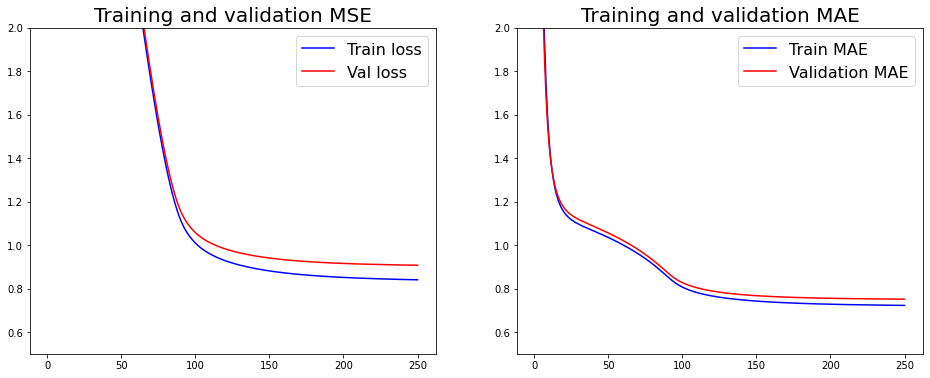

In [ ]:
# MSE
loss_hist = training_2.history['loss']
val_loss_hist = training_2.history['val_loss']
# MAE
train_mae_hist = training_2.history['mae']
val_mae_hist = training_2.history['val_mae']
epochs = range(1, len(loss_hist) + 1)

fig, axs = plt.subplots(1,2,figsize=(16,6))
axs[0].plot(epochs, loss_hist, 'b', label='Train loss')
axs[0].plot(epochs, val_loss_hist, 'r', label='Val loss')
axs[0].set_title('Training and validation MSE',fontsize=20)
axs[0].legend(fontsize=16)
axs[1].plot(epochs, train_mae_hist, 'b', label='Train MAE')
axs[1].plot(epochs, val_mae_hist, 'r', label='Validation MAE')
axs[1].set_title('Training and validation MAE',fontsize=20)
axs[1].legend(fontsize=16)
axs[0].set_ylim(0.5,2)
axs[1].set_ylim(0.5,2)
plt.show()

## Test

In [ ]:
name = 'Collab_Filtering_bias_reg'
Collab_Filtering_bias_reg.save(path_save+name)
Collab_Filtering_bias_reg.evaluate(x = [x_test[:,0],x_test[:,1]],
                                y = y_test,verbose=2)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_bias_reg/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_bias_reg/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


625/625 - 1s - loss: 0.9032 - mse: 0.9032 - mae: 0.7474


[0.9031936526298523, 0.903190016746521, 0.7473664879798889]

## Ejercicio:

* Obtener para cada usuario las peliculas para las cuales no efectuo ningun ranking.

* Para un usuario determinado, devolver las predicciones de las top 10 ranking --> recomendaciones ! 

# 4) Modelo: NeuMF 

$R_{i,j} = \alpha_{NeuMF}\left( W~\begin{bmatrix} L_{i} \cdot L^{T}_{j}& , & \alpha_{MLP} \left(W~\begin{bmatrix} P_{i}\\ P_{j}\end{bmatrix}\right)~\end{bmatrix} \right) $

Donde:

$L_{i}$ y $L_{j}$ son los *embeddings* del usuario ${i}$ y pelicula ${j}$ de la rama del dot product$.

$P_{i}$ y $P_{j}$ son los *embeddings* del usuario ${i}$ y pelicula ${j}$ de la rama MLP.

$\alpha_{MLP}$ y $\alpha_{NeuMF}$ son funciones de activacion y los $W$ son parametros a aprender por la red.



In [ ]:
# Dot
lattent_space_dot = 50

embedding2mlp = 50
MLP = [60 ,30 ,30,15]
pred_list = [50,50,1]

Model: "Collab_Filtering_MLP"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_user (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
x_movies (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
u_vector_mlp (Embedding)        (None, 1, 50)        47150       x_user[0][0]                     
__________________________________________________________________________________________________
m_vector_mlp (Embedding)        (None, 1, 50)        84100       x_movies[0][0]                   
_______________________________________________________________________________

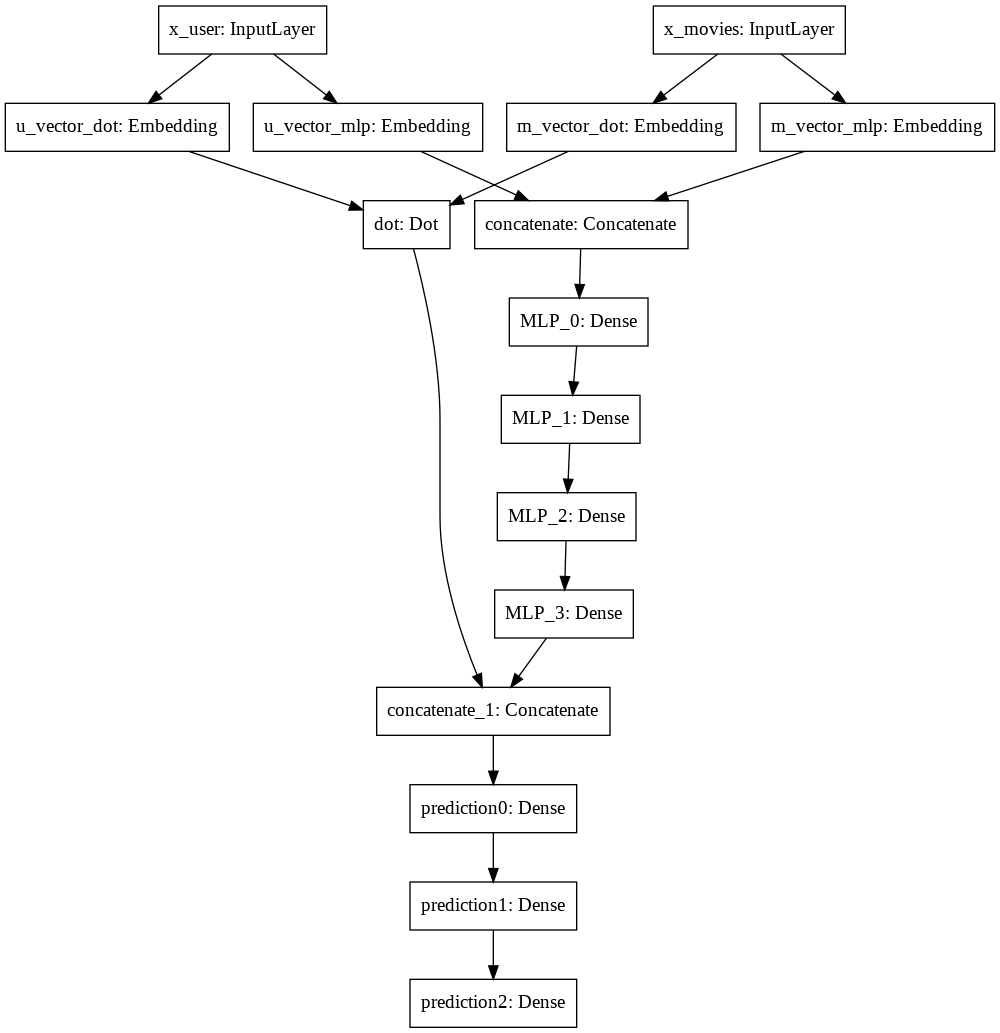

In [ ]:
# Para eliminar los modelos que hayan quedado guardados en memoria
tf.keras.backend.clear_session() 

lambda_value = 5e-3

input_x_user = Input(shape=(1), name="x_user")
input_x_movies = Input(shape=(1), name="x_movies")


# Rama de Usuarios - DOT
user_vector_dot = Embedding(input_dim = q_users,output_dim = lattent_space_dot,
                        embeddings_regularizer=regularizers.l2(lambda_value),
                         name="u_vector_dot")(input_x_user)
user_bias_dot = Embedding(input_dim = q_users,output_dim = 1,
                       name="u_bias")(input_x_user)
# Rama de Peliculas - DOT
movie_vector_dot = Embedding(input_dim = q_movies,output_dim = lattent_space_dot,
                         embeddings_regularizer=regularizers.l2(lambda_value),
                          name="m_vector_dot")(input_x_movies)
movie_bias_dot = Embedding(input_dim = q_movies,output_dim = 1,
                        name="m_bias")(input_x_movies)
# Rama de Usuarios - MLP
user_vector_mlp = Embedding(input_dim = q_users,output_dim = lattent_space_dot,
                        embeddings_regularizer=regularizers.l2(lambda_value),
                         name="u_vector_mlp")(input_x_user)
# Rama de Peliculas - MLP
movie_vector_mlp = Embedding(input_dim = q_movies,output_dim = lattent_space_dot,
                         embeddings_regularizer=regularizers.l2(lambda_value),
                          name="m_vector_mlp")(input_x_movies)

# Dot Product User*Movie                     
users_movies_dot = Dot(axes=2)([user_vector_dot, movie_vector_dot])

# MLP Layers
# Concat
users_movies_mlp = tf.keras.layers.Concatenate()([user_vector_mlp, movie_vector_mlp])
for i,i_dim in enumerate(MLP):
  users_movies_mlp = Dense(units = i_dim,activation='relu',kernel_regularizer=regularizers.l2(lambda_value),
                          name = 'MLP_'+str(i))(users_movies_mlp)

# Concatenamos la rama dot y la rama MLP
prediction = tf.keras.layers.Concatenate()([users_movies_dot,users_movies_mlp])
for i,i_dim in enumerate(pred_list):
  prediction = Dense(units= i_dim, name='prediction'+str(i), 
                     activation='linear' if i ==2 else 'relu')(prediction)

Collab_Filtering_MLP = Model(inputs = [input_x_user,input_x_movies],
                         outputs = prediction, name="Collab_Filtering_MLP")
Collab_Filtering_MLP.summary()
tf.keras.utils.plot_model(Collab_Filtering_MLP)

In [ ]:
# Optimizador
lr = 0.001
opt = Adam(learning_rate=lr)
# Funcion de penalizacion
# Usar ésta loss cuando tenemos un problema multi-class.
loss_func = MeanSquaredError()

# Compilamos
Collab_Filtering_MLP.compile(optimizer = opt,
              loss = loss_func,
              metrics = ['mse','mae'])

## Train

In [ ]:
# Para guardar el modelo cuando la loss de validacion mejora.
name = 'Collab_Filtering_MLP'
callback_chp = tf.keras.callbacks.ModelCheckpoint(
    path_save+name,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False)
# Entrenamos!
training_3 = Collab_Filtering_MLP.fit(x = [x_train[:,0],x_train[:,1]],
                                y = y_train,
                                batch_size = bs,
                                epochs=epochs_training*2,
                                validation_data = ([x_val[:,0],x_val[:,1]],y_val),
                                callbacks=[callbacks_fn,callback_chp],
                                verbose=1)

Epoch 1/100
500/500 [==============================] - 5s 7ms/step - loss: 2.1273 - mse: 1.6899 - mae: 0.9568 - val_loss: 1.1950 - val_mse: 0.9618 - val_mae: 0.7685
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 2/100
500/500 [==============================] - 3s 5ms/step - loss: 1.1230 - mse: 0.9314 - mae: 0.7681 - val_loss: 1.0968 - val_mse: 0.9348 - val_mae: 0.7776
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 3/100
500/500 [==============================] - 3s 5ms/step - loss: 1.0713 - mse: 0.9245 - mae: 0.7649 - val_loss: 1.0500 - val_mse: 0.9165 - val_mae: 0.7610
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 4/100
500/500 [==============================] - 3s 5ms/step - loss: 1.0439 - mse: 0.9180 - mae: 0.7614 - val_loss: 1.0380 - val_mse: 0.9209 - val_mae: 0.7646
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 5/100
500/500 [==============================] - 3s 5ms/step - loss: 1.0234 - mse: 0.9093 - mae: 0.7577 - val_loss: 1.0453 - val_mse: 0.9383 - val_mae: 0.7829
Epoch 6/100
500/500 [==============================] - 3s 5ms/step - loss: 1.0120 - mse: 0.9066 - mae: 0.7558 - val_loss: 1.0328 - val_mse: 0.9352 - val_mae: 0.7844
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 7/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9970 - mse: 0.8980 - mae: 0.7512 - val_loss: 0.9923 - val_mse: 0.9028 - val_mae: 0.7557
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 8/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9822 - mse: 0.8912 - mae: 0.7473 - val_loss: 0.9963 - val_mse: 0.9101 - val_mae: 0.7496
Epoch 9/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9750 - mse: 0.8889 - mae: 0.7468 - val_loss: 0.9798 - val_mse: 0.8977 - val_mae: 0.7456
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 10/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9663 - mse: 0.8824 - mae: 0.7432 - val_loss: 0.9800 - val_mse: 0.9004 - val_mae: 0.7514
Epoch 11/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9657 - mse: 0.8818 - mae: 0.7433 - val_loss: 0.9784 - val_mse: 0.8967 - val_mae: 0.7546
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 12/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9652 - mse: 0.8813 - mae: 0.7425 - val_loss: 0.9713 - val_mse: 0.8958 - val_mae: 0.7430
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 13/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9573 - mse: 0.8784 - mae: 0.7406 - val_loss: 0.9785 - val_mse: 0.9031 - val_mae: 0.7442
Epoch 14/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9517 - mse: 0.8759 - mae: 0.7400 - val_loss: 0.9690 - val_mse: 0.8958 - val_mae: 0.7436
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 15/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9526 - mse: 0.8756 - mae: 0.7399 - val_loss: 0.9775 - val_mse: 0.9034 - val_mae: 0.7446
Epoch 16/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9560 - mse: 0.8775 - mae: 0.7398 - val_loss: 0.9733 - val_mse: 0.9013 - val_mae: 0.7439
Epoch 17/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9472 - mse: 0.8730 - mae: 0.7385 - val_loss: 0.9665 - val_mse: 0.8922 - val_mae: 0.7504
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 18/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9472 - mse: 0.8737 - mae: 0.7395 - val_loss: 0.9692 - val_mse: 0.8960 - val_mae: 0.7448
Epoch 19/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9458 - mse: 0.8721 - mae: 0.7375 - val_loss: 0.9723 - val_mse: 0.8973 - val_mae: 0.7470
Epoch 20/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9445 - mse: 0.8742 - mae: 0.7396 - val_loss: 0.9565 - val_mse: 0.8936 - val_mae: 0.7526
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 21/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9451 - mse: 0.8727 - mae: 0.7381 - val_loss: 0.9722 - val_mse: 0.8984 - val_mae: 0.7459
Epoch 22/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9453 - mse: 0.8703 - mae: 0.7375 - val_loss: 0.9597 - val_mse: 0.8922 - val_mae: 0.7452
Epoch 23/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9399 - mse: 0.8710 - mae: 0.7374 - val_loss: 0.9556 - val_mse: 0.8904 - val_mae: 0.7486
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 24/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9396 - mse: 0.8711 - mae: 0.7381 - val_loss: 0.9789 - val_mse: 0.9070 - val_mae: 0.7439
Epoch 25/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9418 - mse: 0.8701 - mae: 0.7374 - val_loss: 0.9540 - val_mse: 0.8913 - val_mae: 0.7489
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 26/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9381 - mse: 0.8698 - mae: 0.7369 - val_loss: 0.9548 - val_mse: 0.8904 - val_mae: 0.7414
Epoch 27/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9387 - mse: 0.8705 - mae: 0.7374 - val_loss: 0.9556 - val_mse: 0.8897 - val_mae: 0.7463
Epoch 28/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9416 - mse: 0.8702 - mae: 0.7368 - val_loss: 0.9610 - val_mse: 0.8893 - val_mae: 0.7413
Epoch 29/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9405 - mse: 0.8716 - mae: 0.7385 - val_loss: 0.9619 - val_mse: 0.8985 - val_mae: 0.7433
Epoch 30/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9360 - mse: 0.8697 - mae: 0.7365 - val_loss: 0.9516 - val_mse: 0.8881 - val_mae: 0.7461
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 31/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9391 - mse: 0.8710 - mae: 0.7370 - val_loss: 0.9788 - val_mse: 0.9119 - val_mae: 0.7462
Epoch 32/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9345 - mse: 0.8670 - mae: 0.7352 - val_loss: 0.9774 - val_mse: 0.9151 - val_mae: 0.7687
Epoch 33/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9371 - mse: 0.8695 - mae: 0.7374 - val_loss: 1.0043 - val_mse: 0.9395 - val_mae: 0.7548
Epoch 34/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9357 - mse: 0.8685 - mae: 0.7358 - val_loss: 0.9682 - val_mse: 0.9056 - val_mae: 0.7455
Epoch 35/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9324 - mse: 0.8693 - mae: 0.7365 - val_loss: 0.9497 - val_mse: 0.8889 - val_mae: 0.7436
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 36/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9382 - mse: 0.8716 - mae: 0.7381 - val_loss: 0.9768 - val_mse: 0.9165 - val_mae: 0.7484
Epoch 37/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9381 - mse: 0.8701 - mae: 0.7366 - val_loss: 0.9549 - val_mse: 0.8921 - val_mae: 0.7478
Epoch 38/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9347 - mse: 0.8698 - mae: 0.7369 - val_loss: 0.9493 - val_mse: 0.8881 - val_mae: 0.7454
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 39/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9366 - mse: 0.8697 - mae: 0.7362 - val_loss: 0.9616 - val_mse: 0.8907 - val_mae: 0.7432
Epoch 40/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9341 - mse: 0.8690 - mae: 0.7371 - val_loss: 0.9563 - val_mse: 0.8937 - val_mae: 0.7515
Epoch 41/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9343 - mse: 0.8703 - mae: 0.7373 - val_loss: 0.9624 - val_mse: 0.9011 - val_mae: 0.7463
Epoch 42/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9346 - mse: 0.8703 - mae: 0.7370 - val_loss: 0.9535 - val_mse: 0.8941 - val_mae: 0.7502
Epoch 43/100
500/500 [==============================] - 3s 6ms/step - loss: 0.9337 - mse: 0.8702 - mae: 0.7372 - val_loss: 0.9567 - val_mse: 0.8925 - val_mae: 0.7432
Epoch 44/100
500/500 [==============================] - 3s 6ms/step - loss: 0.9359 - mse: 0.8697 - mae: 0.7371 - val_loss: 0.9616 - val_mse: 0.8989 - val_mae: 0.7443
Epoc

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 46/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9338 - mse: 0.8713 - mae: 0.7379 - val_loss: 0.9565 - val_mse: 0.8952 - val_mae: 0.7436
Epoch 47/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9332 - mse: 0.8702 - mae: 0.7376 - val_loss: 0.9519 - val_mse: 0.8946 - val_mae: 0.7536
Epoch 48/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9329 - mse: 0.8685 - mae: 0.7366 - val_loss: 0.9609 - val_mse: 0.8963 - val_mae: 0.7542
Epoch 49/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9348 - mse: 0.8688 - mae: 0.7358 - val_loss: 0.9628 - val_mse: 0.9013 - val_mae: 0.7434
Epoch 50/100
500/500 [==============================] - 3s 6ms/step - loss: 0.9359 - mse: 0.8697 - mae: 0.7366 - val_loss: 0.9476 - val_mse: 0.8871 - val_mae: 0.7489
Epoch 51/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9309 - mse: 0.8683 - mae: 0.7363 - val_loss: 0.9605 - val_mse: 0.8965 - val_mae: 0.7534
Epoc

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 62/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8963 - mse: 0.8496 - mae: 0.7267 - val_loss: 0.9317 - val_mse: 0.8863 - val_mae: 0.7409
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 63/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8982 - mse: 0.8498 - mae: 0.7267 - val_loss: 0.9368 - val_mse: 0.8900 - val_mae: 0.7489
Epoch 64/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8990 - mse: 0.8489 - mae: 0.7262 - val_loss: 0.9348 - val_mse: 0.8865 - val_mae: 0.7415
Epoch 65/100
500/500 [==============================] - 3s 5ms/step - loss: 0.9008 - mse: 0.8505 - mae: 0.7278 - val_loss: 0.9347 - val_mse: 0.8854 - val_mae: 0.7428
Epoch 66/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8984 - mse: 0.8507 - mae: 0.7274 - val_loss: 0.9346 - val_mse: 0.8883 - val_mae: 0.7416
Epoch 67/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8994 - mse: 0.8508 - mae: 0.7272 - val_loss: 0.9467 - val_mse: 0.8997 - val_mae: 0.7420
Epoch 68/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8981 - mse: 0.8516 - mae: 0.7273 - val_loss: 0.9384 - val_mse: 0.8936 - val_mae: 0.7512
Epoc

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 71/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8979 - mse: 0.8506 - mae: 0.7268 - val_loss: 0.9315 - val_mse: 0.8868 - val_mae: 0.7445
Epoch 72/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8962 - mse: 0.8511 - mae: 0.7273 - val_loss: 0.9312 - val_mse: 0.8868 - val_mae: 0.7440
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 73/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8970 - mse: 0.8503 - mae: 0.7269 - val_loss: 0.9345 - val_mse: 0.8874 - val_mae: 0.7430
Epoch 74/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8973 - mse: 0.8507 - mae: 0.7271 - val_loss: 0.9327 - val_mse: 0.8870 - val_mae: 0.7420
Epoch 75/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8984 - mse: 0.8536 - mae: 0.7284 - val_loss: 0.9312 - val_mse: 0.8870 - val_mae: 0.7421
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 76/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8952 - mse: 0.8523 - mae: 0.7275 - val_loss: 0.9495 - val_mse: 0.9087 - val_mae: 0.7620
Epoch 77/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8975 - mse: 0.8520 - mae: 0.7274 - val_loss: 0.9309 - val_mse: 0.8860 - val_mae: 0.7415
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 78/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8954 - mse: 0.8499 - mae: 0.7265 - val_loss: 0.9310 - val_mse: 0.8880 - val_mae: 0.7471
Epoch 79/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8970 - mse: 0.8519 - mae: 0.7278 - val_loss: 0.9315 - val_mse: 0.8876 - val_mae: 0.7447
Epoch 80/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8973 - mse: 0.8525 - mae: 0.7277 - val_loss: 0.9328 - val_mse: 0.8883 - val_mae: 0.7424
Epoch 81/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8962 - mse: 0.8521 - mae: 0.7286 - val_loss: 0.9298 - val_mse: 0.8871 - val_mae: 0.7417
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 82/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8936 - mse: 0.8508 - mae: 0.7274 - val_loss: 0.9310 - val_mse: 0.8888 - val_mae: 0.7461
Epoch 83/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8955 - mse: 0.8517 - mae: 0.7277 - val_loss: 0.9312 - val_mse: 0.8881 - val_mae: 0.7433
Epoch 84/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8958 - mse: 0.8508 - mae: 0.7269 - val_loss: 0.9403 - val_mse: 0.8983 - val_mae: 0.7554
Epoch 85/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8946 - mse: 0.8513 - mae: 0.7272 - val_loss: 0.9384 - val_mse: 0.8951 - val_mae: 0.7403
Epoch 86/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8966 - mse: 0.8528 - mae: 0.7285 - val_loss: 0.9743 - val_mse: 0.9310 - val_mae: 0.7500
Epoch 87/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8994 - mse: 0.8533 - mae: 0.7280 - val_loss: 0.9340 - val_mse: 0.8885 - val_mae: 0.7447
Epoc

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


Epoch 89/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8936 - mse: 0.8517 - mae: 0.7279 - val_loss: 0.9424 - val_mse: 0.8994 - val_mae: 0.7428
Epoch 90/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8933 - mse: 0.8511 - mae: 0.7276 - val_loss: 0.9311 - val_mse: 0.8876 - val_mae: 0.7396
Epoch 91/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8967 - mse: 0.8528 - mae: 0.7282 - val_loss: 0.9294 - val_mse: 0.8869 - val_mae: 0.7418
Epoch 92/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8978 - mse: 0.8528 - mae: 0.7287 - val_loss: 0.9351 - val_mse: 0.8891 - val_mae: 0.7463
Epoch 93/100
500/500 [==============================] - 3s 6ms/step - loss: 0.8933 - mse: 0.8503 - mae: 0.7270 - val_loss: 0.9364 - val_mse: 0.8925 - val_mae: 0.7497
Epoch 94/100
500/500 [==============================] - 3s 5ms/step - loss: 0.8932 - mse: 0.8503 - mae: 0.7277 - val_loss: 0.9412 - val_mse: 0.8973 - val_mae: 0.7427
Epoc

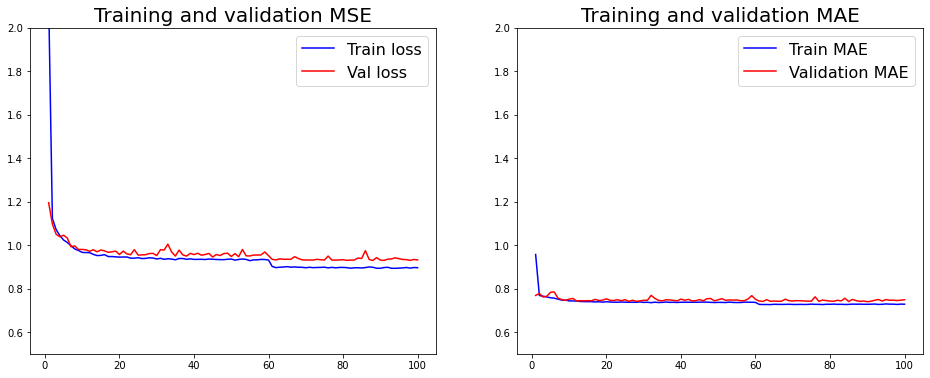

In [ ]:
# MSE
losshist = training_3.history['loss']
val_loss_hist = training_3.history['val_loss']
# MAE
train_maehist = training_3.history['mae']
val_mae_hist = training_3.history['val_mae']
epochs = range(1, len(losshist) + 1)

fig, axs = plt.subplots(1,2,figsize=(16,6))
axs[0].plot(epochs, losshist, 'b', label='Train loss')
axs[0].plot(epochs, val_loss_hist, 'r', label='Val loss')
axs[0].set_title('Training and validation MSE',fontsize=20)
axs[0].legend(fontsize=16)
axs[1].plot(epochs, train_maehist, 'b', label='Train MAE')
axs[1].plot(epochs, val_mae_hist, 'r', label='Validation MAE')
axs[1].set_title('Training and validation MAE',fontsize=20)
axs[1].legend(fontsize=16)
axs[0].set_ylim(0.5,2)
axs[1].set_ylim(0.5,2)
plt.show()

## Test

In [ ]:
Collab_Filtering_MLP = tf.keras.models.load_model(path_save+name)
Collab_Filtering_MLP.evaluate(x = [x_test[:,0],x_test[:,1]],
                                y = y_test,verbose=2)

625/625 - 1s - loss: 0.9229 - mse: 0.8800 - mae: 0.7363


[0.9229475855827332, 0.8799687623977661, 0.7363421320915222]

In [ ]:
name = 'Collab_Filtering_MLP'
Collab_Filtering_MLP.save(path_save+name)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/ClusterAI/Iris/save/Collab_Filtering_MLP/assets
